In [1]:
import numpy as np
import numpy.random as rand
from functools import cache
import polars as pl
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn
import pandas as pd

In [2]:
TARGET = "quality"
df = pl.read_csv("data/Wine_Quality_Data.csv", has_header=True)
df = df.drop("color")
df = df.head(1000)

In [3]:
df.describe()

describe,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",8.7289,0.52829,0.29458,2.5794,0.090375,15.171,48.328,0.997349,3.2991,0.66852,10.2407,5.594
"""std""",1.836602,0.17855,0.200153,1.23896,0.049917,9.972949,33.309788,0.001778,0.157948,0.18321,1.033161,0.798625
"""min""",4.6,0.12,0.0,1.2,0.012,1.0,6.0,0.99064,2.74,0.33,8.4,3.0
"""max""",15.9,1.33,1.0,15.5,0.611,68.0,165.0,1.0032,3.9,2.0,14.9,8.0
"""median""",8.3,0.52,0.28,2.3,0.081,13.0,39.0,0.9973,3.3,0.62,9.9,5.0
"""25%""",7.4,0.4,0.12,2.0,0.072,7.0,23.0,0.99639,3.19,0.56,9.5,5.0
"""75%""",9.8,0.635,0.47,2.7,0.093,21.0,65.0,0.9984,3.4,0.74,10.8,6.0


In [4]:
from sklearn.model_selection import KFold
import polars as pl
import itertools

def fetch_data(df, use_split, rbf, include_mul, raw_vals):
    assert(use_split >= 0 and use_split <= 4)
    # Perform 5-fold cross validation with a deterministic seed
    kf = KFold(n_splits=4, shuffle=True, random_state=2023)
    splits = list(kf.split(df))
    # Indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    for col in df_train.columns:
        if col == TARGET or col in rbf:
            continue
        df_train, df_test = scale_column(df_train, df_test, col)
    cols = list(df_train.columns)
    # binary = binary_columns(df_train)
    for (idx, col) in enumerate(rbf):
        if col == TARGET:
            continue
        dist = int(10 * abs(0.5 - raw_vals[idx]))
        dist = np.clip(dist, 0, 5)
        df_train, df_test = rbf_column(df_train, df_test, col, num_features=dist) # Use radial bias function
    for (idx, col) in enumerate(cols):
        if col == TARGET:
            continue
        if col not in rbf:
            dist = int(10 * abs(0.5 - raw_vals[idx]))
            dist = np.clip(dist, 0, 5)
            df_train, df_test = fourier_column(df_train, df_test, col, num_features=dist)
    for (col_a, col_b) in itertools.combinations(cols, 2):
        if col_a == TARGET or col_b == TARGET:
            continue
        if col_a not in include_mul and col_b not in include_mul:
            continue
        df_train, df_test = mul_cols(df_train, df_test, col_a, col_b)
    return df_train, df_test

def binary_columns(df):
    binary = []
    for col in df.columns:
        if df.get_column(col).n_unique() == 2:
            binary.append(col)
    return binary

def scale_column(df_train, df_test, col_name):
    '''Scale a column from 0 to 1'''
    max = df_train.get_column(col_name).max()
    min = df_train.get_column(col_name).min()
    df_train = df_train.with_columns((pl.col(col_name) - min) / (max - min))
    df_test = df_test.with_columns((pl.col(col_name) - min) / (max - min))
    return df_train, df_test

def rbf_column(df_train, df_test, col_name, num_features=3):
    '''Divide a col into 3 features using a radial basis function'''
    std = df_train.get_column(col_name).std()
    select = []
    if num_features == 2:
        low = df_train.get_column(col_name).quantile(0.25)
        high = df_train.get_column(col_name).quantile(0.75)
        select = [low, high]
    elif num_features == 3:
        low = df_train.get_column(col_name).quantile(0.25)
        middle = df_train.get_column(col_name).quantile(0.5)
        high = df_train.get_column(col_name).quantile(0.75)
        select = [low, middle, high]
    elif num_features == 4:
        low = df_train.get_column(col_name).quantile(0.2)
        middle = df_train.get_column(col_name).quantile(0.4)
        high = df_train.get_column(col_name).quantile(0.6)
        higher = df_train.get_column(col_name).quantile(0.8)
        select = [low, middle, high, higher]
    elif num_features == 5:
        low = df_train.get_column(col_name).quantile(0.15)
        middle = df_train.get_column(col_name).quantile(0.3)
        high = df_train.get_column(col_name).quantile(0.45)
        higher = df_train.get_column(col_name).quantile(0.6)
        highest = df_train.get_column(col_name).quantile(0.75)
        select = [low, middle, high, higher, highest]
    for i, val in enumerate(select):
        df_train = df_train.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
        df_test = df_test.with_columns((-1.0 * (pl.col(col_name) - val)**2 / (2 * std)**2).exp().alias(f"{col_name}_{i}"))
    return df_train, df_test

def fourier_column(df_train, df_test, col_name, num_features=3):
    '''Divide a col in 3 features using math'''
    for i in range(1, num_features + 1):
        df_train = df_train.with_columns((pl.col(col_name) * pl.lit(i) * pl.lit(np.pi)).cos().alias(f"{col_name}_{i - 1}"))
        df_test = df_test.with_columns((pl.col(col_name) * pl.lit(i) * pl.lit(np.pi)).cos().alias(f"{col_name}_{i - 1}"))
    return df_train, df_test

def mul_cols(df_train, df_test, col_a, col_b):
    df_train = df_train.with_columns((pl.col(col_a) * pl.col(col_b)).alias(f"{col_a}+{col_b}"))
    df_test = df_test.with_columns((pl.col(col_a) * pl.col(col_b)).alias(f"{col_a}+{col_b}"))
    return df_train, df_test

def get_x_y(df):
    X, y = df.drop(TARGET), df.get_column(TARGET)
    return X.to_numpy(), y.to_numpy()

NUM_FEATURES = len(df.columns) - 1
df_train, df_test = fetch_data(df, 0, list(df.columns)[11:], [], np.ones(NUM_FEATURES * 2))
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
len(y_train)

750

In [5]:
NUM_FEATURES

11

In [6]:
a = np.array(list(df.columns[1:]) + list(df.columns[1:]))
len(a)

22

In [7]:
def evaluate(input, model='tree', verbose=False): # model = tree, svm, logistic, knn
    a = np.array(list(df.columns[1:]) + list(df.columns[1:]))
    rbf = a[input > 0.5]
    df_train, df_test = fetch_data(df, 0, rbf[:NUM_FEATURES], rbf[NUM_FEATURES:], input)
    if verbose:
        print("Fetched Data")
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    if verbose:
        print("Split data")

    if model == 'logistic': reg = LogisticRegression(solver="newton-cg", random_state=420)
    elif model == 'svm': reg = LinearSVC(random_state=420)
    elif model == 'tree': reg = DecisionTreeClassifier(random_state=420)
    elif model == 'knn': reg = KNeighborsClassifier()
    else: reg = None
    if verbose:
        print("Fitting Data")
    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test)

In [8]:
np.array(list(df.columns[1:]))

array(['volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
       'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH',
       'sulphates', 'alcohol', 'quality'], dtype='<U20')

In [9]:
NUM_DIM = NUM_FEATURES * 2
LIMIT = 4

class Configuration:
    def __init__(self, array):
        self.data = np.clip(array, 0.0, 1.0)

    def __hash__(self):
        return hash(self.data.tobytes())
    
    def __eq__(self, other):
        return (self.data == other.data).all()

class Solutions:
    def __init__(self, num, model='fhsdkfhkd', ring_size=4, seed=4222023):
        self.rng = rand.Generator(rand.PCG64(seed))
        self.solutions = np.stack([self.new_solution() for _ in range(num)])
        self.employed = np.array([True] * (num // 2) + [False] * (num // 2))
        self.failures = np.zeros_like(self.employed, np.int32)
        self.onlooker = np.logical_not(self.employed) # Unemployed
        self.best_fitness = -1
        self.best_sol = None 
        self.ring_size = ring_size
        self.model = model

    def new_solution(self):
        return self.rng.random(size=NUM_DIM)
    
    def best_in_ring(self, start_idx):
        # sol = self.solutions[start_idx]
        size = len(self.solutions)
        best_idx = start_idx 
        for i in range(1, 1 + self.ring_size):
            idx = (start_idx - i) % size
            if self.fitness(self.solutions[idx]) > self.fitness(self.solutions[best_idx]):
                best_idx = idx
        for i in range(1, 1 + self.ring_size):
            idx = (start_idx + i) % size
            if self.fitness(self.solutions[idx]) > self.fitness(self.solutions[best_idx]):
                best_idx = idx
        return best_idx
        

    def random_sol(self, exclude=-1):
        rand_idx = self.rng.integers(0, self.solutions.shape[0])
        if rand_idx == exclude:
            return self.random_sol(exclude=exclude)
        else:
            return self.solutions[rand_idx]

    def get_employed(self):
        return self.solutions[self.employed]

    def get_unemployed(self):
        return self.solutions[np.logical_not(self.employed)]
        
    def get_onlooker(self):
        return self.solutions[self.onlooker]

    def get_scout(self):
        return self.solutions[self.scout]

    def fitness(self, x):
        return _fitness(Configuration(x), self.model)

    def most_fit(self):
        fit = np.array([self.fitness(x) for x in self.solutions])
        idx = fit.argmax()
        return fit[idx], self.solutions[idx]

    def update_best(self):
        best_fit, best_sol = self.most_fit()
        if best_fit > self.best_fitness:
            self.best_sol = best_sol
            self.best_fitness = best_fit

@cache
def _fitness(x: Configuration, model):
    return evaluate(x.data, model)

def employed_fn(sol: Solutions, initial_idx: int, enhanced=False):
    initial = sol.solutions[initial_idx]
    a = 0.1
    idx = sol.rng.integers(0, initial.size)
    phi = sol.rng.uniform(low=-a, high=a)
    out = np.copy(initial)
    if enhanced: 
        best_idx = sol.best_in_ring(initial_idx)
        sol_k = sol.solutions[best_idx]
    else:
        sol_k = sol.random_sol(exclude=initial_idx)
    out[idx] += phi * (out[idx] - sol_k[idx])
    out = np.clip(out, 0, 1)
    return out

def basic_onlooker(sol: Solutions, _initial_idx: int):
    employed = sol.get_employed()
    fitnesses = np.array([sol.fitness(x) for x in employed])
    total_fitness = np.sum(fitnesses)
    bee_idx = sol.rng.choice(np.arange(len(employed)), p=fitnesses/total_fitness)
    return employed_fn(sol, bee_idx)

def enhanced_onlooker(sol: Solutions, initial_idx: int):
    best_bee = sol.solutions[sol.best_in_ring(initial_idx)]
    random_bee_idx = sol.rng.choice(len(sol.solutions))
    random_bee = sol.solutions[random_bee_idx]
    a = 0.1 
    idx = sol.rng.integers(0, best_bee.size)
    phi = sol.rng.uniform(low=-a, high=a)
    out = np.copy(best_bee)
    out[idx] += phi * (out[idx] - random_bee[idx])
    out = np.clip(out, 0, 1)
    return out

def vanilla_abc(num_bees, epochs):
    return abc(num_bees, epochs, basic_onlooker, smart_scout=False, smart_employed=False)

def abc(num_bees, epochs, onlooker_fn, smart_scout=False, smart_employed=False, model='tree', quiet=True):
    sol = Solutions(num_bees, model)
    for _ in range(epochs):
        # Employed
        for idx in sol.employed.nonzero()[0]:
            candidate = employed_fn(sol, idx, smart_employed)
            if sol.fitness(candidate) > sol.fitness(sol.solutions[idx]):
                sol.solutions[idx] = candidate
                sol.failures[idx] = 0
            else:
                sol.failures[idx] += 1
        # Onlooker
        for idx in sol.onlooker.nonzero()[0]:
            candidate = onlooker_fn(sol, idx)
            if sol.fitness(candidate) > sol.fitness(sol.solutions[idx]):
                sol.solutions[idx] = candidate
        # Scout
        for idx in sol.employed.nonzero()[0]:
            if sol.failures[idx] >= LIMIT:
                sol.failures[idx] = 0
                sol.solutions[idx, :] = sol.new_solution()
            if smart_scout:
                new_fitness = sol.fitness(sol.solutions[idx])
                # Candidate U2
                r1 = sol.random_sol()
                r2 = sol.random_sol()
                best = sol.solutions[sol.best_in_ring(idx)]
                diff = r1 - r2
                weighted = sol.rng.random(diff.size) * diff
                candidate = np.copy(best)
                candidate += weighted
                u2_fit = sol.fitness(candidate)
                if u2_fit > new_fitness:
                    new_fitness = u2_fit 
                    sol.solutions[idx, :] = candidate
                # Candidate U3
                # Assume in range 0 to 1
                opposite = np.ones_like(best) - best
                u3_fit = sol.fitness(opposite)
                if u3_fit > new_fitness:
                    sol.solutions[idx, :] = opposite
            
        # Mark best
        sol.update_best()
        if not quiet:
            print(sol.best_fitness)
            print(sol.best_sol)
    return sol

In [10]:
RUN = False

In [28]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = abc(100, 10, enhanced_onlooker, smart_scout=True, smart_employed=True, model='tree', quiet=False)

0.676
[0.50594685 0.04007017 0.65670536 1.1163467  0.03319634 0.02216555
 0.49159073 0.11227696 0.69060652 0.34015346 0.75867027 0.87280105
 0.71186283 0.51079368 0.44424384 0.1935531  0.45525937 0.53489503
 0.49072378 0.55762527 0.3369291  0.37424863]
0.676
[0.50594685 0.04007017 0.65670536 1.1163467  0.03319634 0.02216555
 0.49159073 0.11227696 0.69060652 0.34015346 0.75867027 0.87280105
 0.71186283 0.51079368 0.44424384 0.1935531  0.45525937 0.53489503
 0.49072378 0.55762527 0.3369291  0.37424863]
0.68
[ 0.61281367  1.07697554  0.19817581  0.18067763  0.99805916  0.95662683
  0.39915955  1.01424343  0.64902229  0.73535308  0.25177016 -0.72763535
  0.15706156  0.4495057   0.48032935  0.71869206  0.52959066  0.44351607
  0.5758769   1.03906067  0.00441173  0.49226234]
0.68
[0.74834169 0.67481596 0.14448828 0.16071    0.18979139 0.04912329
 0.2760839  0.75185675 0.17271058 0.97251297 0.05857075 0.41586019
 0.46961588 0.70886678 0.35259047 0.83134407 0.54898362 0.78631522
 0.62725557 0.

In [14]:
import warnings
if RUN:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        best = abc(80, 2**10, enhanced_onlooker, True, True)
        best_sol = best.best_sol
        best_acc = best.best_fitness

else:
    best_sol = np.array([ 1.41758502e-01,  5.36575656e-01,  1.52264166e-01,  5.22438538e-01,
        8.53801988e-01,  3.42520398e-02,  7.00347225e-02,  5.84034794e-01,
        2.87205723e+01,  1.13782776e+04, -1.35060538e+04, -8.34848191e+03,
       -2.19114797e+03, -3.10108235e+03,  1.77171210e+01, -3.28302531e+03,
       -1.82234877e+04,  3.37441394e-01, -2.34847110e+03,  8.42227212e-02,
        6.08844870e-01, -1.99673131e+02])
    best_acc = 0.724

In [30]:
# Best Random Forest 0.74 [0.52904654 0.81420687 0.64489839 0.7312731  0.27315985 0.97688487
#  0.57291268 0.28252793 0.22780821 0.6718864  0.16589953 0.81165986
#  0.91879719 0.36721561 0.20586594 0.09941241 0.58837168 0.23499118
#  0.21606769 0.41012035 0.447105   0.16644631]

In [31]:
# Best DecisionTree 0.716 [ 0.49781814  0.27629634  0.7451372   0.57612247  0.8015136   0.07614703
#  -1.23652068  0.60414707  0.57149879  0.52726963  0.58626366 -0.51605658
#   0.52291123  0.46263772  2.53687284  0.36810732  0.49246265 -0.23834081
#   1.93182876  0.86507608  0.22388496  0.69642921]

In [32]:
# Best DecisionTree 0.744
vals = np.array([0.47814596, 0.5348577, 0.75409125, 0.93711038, 0.93402507, 0.80108002,
 0.38969105, 0.52728978, 0.40916796, 0.67543753, 0.12029326, 0.52322336,
 0.17724371, 0.03142871, 0.95574856, 0.9284217,  0.94973273, 0.70183991,
 0.62261783, 0.22162607, 0.23216788, 0.16600173])
vals[:NUM_FEATURES]

array([0.47814596, 0.5348577 , 0.75409125, 0.93711038, 0.93402507,
       0.80108002, 0.38969105, 0.52728978, 0.40916796, 0.67543753,
       0.12029326])

In [33]:
vals[NUM_FEATURES:]

array([0.52322336, 0.17724371, 0.03142871, 0.95574856, 0.9284217 ,
       0.94973273, 0.70183991, 0.62261783, 0.22162607, 0.23216788,
       0.16600173])

In [34]:
best_sol[NUM_FEATURES:]

array([-8.34848191e+03, -2.19114797e+03, -3.10108235e+03,  1.77171210e+01,
       -3.28302531e+03, -1.82234877e+04,  3.37441394e-01, -2.34847110e+03,
        8.42227212e-02,  6.08844870e-01, -1.99673131e+02])

In [16]:
import pandas as pd

scores = []

for i in range(NUM_FEATURES):
    for _ in range(100):
        new_vals = np.copy(best_sol)
        r = rand.uniform()
        new_vals[i] = r
        score = evaluate(new_vals)
        scores.append({ 'dim': i, 'score': score })

data = pd.DataFrame.from_records(scores)

In [36]:
# ouch = np.array([0.141758502, 0.536575656, 0.152264166, 0.522438538, 0.853801988, 0.0342520398, 0.0700347225, 0.584034794, 
#                  0.226881221289003, 11378.2776, -13506.0538, -8348.48191, -2191.14797, -3101.08235, 17.717121, -3283.02531, 
#                  -18223.4877, 0.337441394, -2348.4711, 
#                  0.0842227212, 0.60884487, -199.673131])
# okay = np.copy(ouch)
# okay[8] = 0.7968510552842712
# print(okay)
# evaluate(ouch, "tree", verbose=True)

[ 1.41758502e-01  5.36575656e-01  1.52264166e-01  5.22438538e-01
  8.53801988e-01  3.42520398e-02  7.00347225e-02  5.84034794e-01
  7.96851055e-01  1.13782776e+04 -1.35060538e+04 -8.34848191e+03
 -2.19114797e+03 -3.10108235e+03  1.77171210e+01 -3.28302531e+03
 -1.82234877e+04  3.37441394e-01 -2.34847110e+03  8.42227212e-02
  6.08844870e-01 -1.99673131e+02]
Fetched Data
Split data
Fitting Data


0.672

In [37]:
data

,dim,score
0,0,0.632
1,0,0.668
2,0,0.668
3,0,0.640
4,0,0.724
...,...,...
105,10,0.724
106,10,0.724
107,10,0.724
108,10,0.668


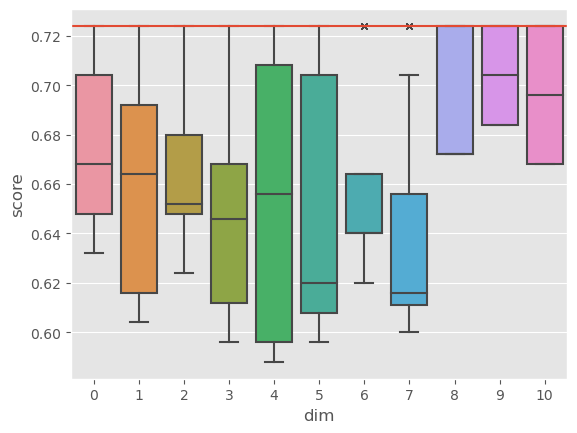

In [17]:
import seaborn

f, ax = plt.subplots()

seaborn.boxplot(data=data, x="dim", y="score", flierprops={"marker": "x"}, ax=ax)
ax.hlines(best_acc, ax.get_xlim()[0], ax.get_xlim()[1])

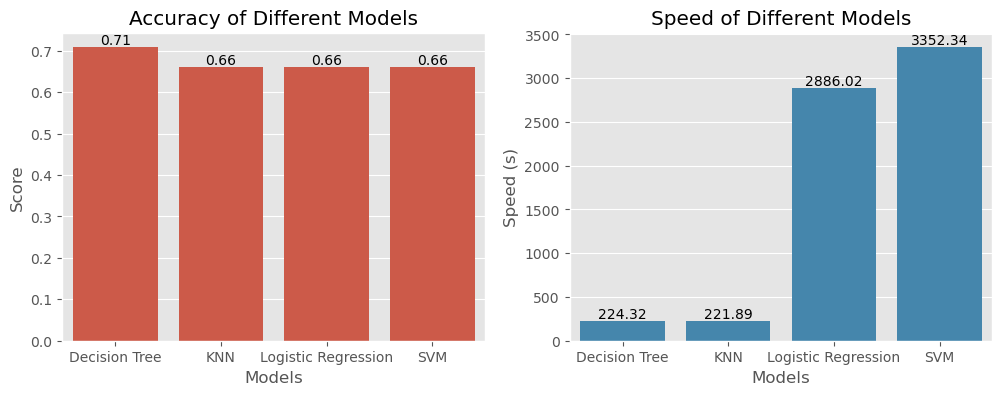

In [11]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import datetime

plt.style.use('ggplot')
COLORS = seaborn.color_palette()
f, ax = plt.subplots(1, 2, figsize=(12, 4))

RUN = False
models = ['Decision Tree', 'KNN', 'Logistic Regression', 'SVM']
if RUN:
    scores = []
    speed = []
    check = ["tree", "logistic", "svm"]
    for model in ["logistic"]:
        st = datetime.datetime.now()
        res = abc(80, 160, enhanced_onlooker, True, True, model)
        diff = datetime.datetime.now() - st
        scores.append(res.best_fitness)
        speed.append(diff.total_seconds())
        break

else:
    # Tree, KNN, Log?, SVM?
    scores = [0.708, 0.66, 0.66, 0.66] 
    speed = [224.32, 221.89, 2886.02, 3352.34] 

plot_df = pd.DataFrame.from_dict({'Score': scores, 'Models': models})
ax[0].set_title('Accuracy of Different Models')
seaborn.barplot(data=plot_df, x='Models', y='Score', ax=ax[0], color=COLORS[0])
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.2f')


plot_df = pd.DataFrame.from_dict({'Speed (s)': speed, 'Models': models})
ax[1].set_title('Speed of Different Models')
seaborn.barplot(data=plot_df, x='Models', y='Speed (s)', ax=ax[1], color=COLORS[1])
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.2f')

In [12]:
scores

[0.66]

In [13]:
speed

[221.894172]

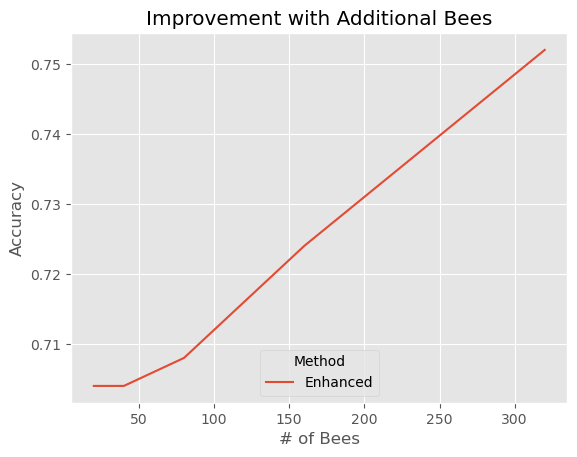

In [20]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np

RUN = False

plt.style.use('ggplot')
COLORS = seaborn.color_palette()
f, ax = plt.subplots()

bees = [20, 40, 80, 160, 320]
if RUN:
    # vanilla = np.array([vanilla_abc(b, 100).best_fitness for b in bees])
    enhanced_abc = np.array([abc(b, 80, enhanced_onlooker, True, True).best_fitness for b in bees])
else:
    enhanced_abc = np.array([0.704, 0.704, 0.708, 0.724, 0.752])

method = ['Vanilla' for _ in range(len(bees))] + ['Enhanced' for _ in range(len(bees))]
plot_df = pd.DataFrame.from_dict({'Accuracy': enhanced_abc, 'Method': ['Enhanced' for _ in range(len(bees))], '# of Bees': bees})
# plot_df = pd.DataFrame.from_dict({'Accuracy': np.concatenate([vanilla, enhanced_abc]), 'Method': method, '# of Bees': bees + bees})
ax.set_title('Improvement with Additional Bees')
seaborn.lineplot(data=plot_df, x='# of Bees', y='Accuracy', hue='Method', ax=ax, palette=COLORS[0:1])
seaborn.move_legend(ax, 'lower center')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

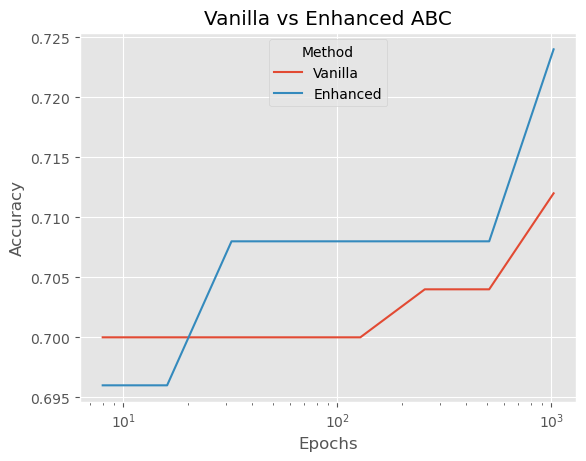

In [47]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np

RUN = False

plt.style.use('ggplot')
COLORS = seaborn.color_palette()
f, ax = plt.subplots()
epochs = [2**(i + 3) for i in range(8)]
if RUN:
    vanilla = np.array([vanilla_abc(80, e).best_fitness for e in epochs])
    enhanced_abc = np.array([abc(80, e, enhanced_onlooker, True, True).best_fitness for e in epochs])
else:
    # Saved values from our 
    enhanced_abc = np.array([0.696, 0.696, 0.708, 0.708, 0.708, 0.708, 0.708, 0.724])
    vanilla = np.array([0.7  , 0.7  , 0.7  , 0.7  , 0.7  , 0.704, 0.704, 0.712])

method = ['Vanilla' for _ in range(len(epochs))] + ['Enhanced' for _ in range(len(epochs))]
plot_df = pd.DataFrame.from_dict({'Accuracy': np.concatenate([vanilla, enhanced_abc]), 'Method': method, 'Epochs': epochs + epochs})
ax.set_title('Vanilla vs Enhanced ABC')
ax.set_xscale("log")
seaborn.lineplot(data=plot_df, x='Epochs', y='Accuracy', hue='Method', ax=ax, palette=COLORS[0:2])
seaborn.move_legend(ax, 'upper center')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')